# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# !pip install torchvision
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# !pip install torchmetrics
import torchmetrics

# Loading and preprocessing dataset

In [2]:
ROOT = "E:/Deep-Learning-Lab/data"
batch_size = 60

In [3]:
train_dataset = datasets.MNIST(root=ROOT,
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

100%|██████████| 9.91M/9.91M [00:22<00:00, 448kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 98.1kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 675kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.74MB/s]


In [4]:
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [5]:
test_dataset = datasets.MNIST(root=ROOT,
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True)

In [6]:
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=True)

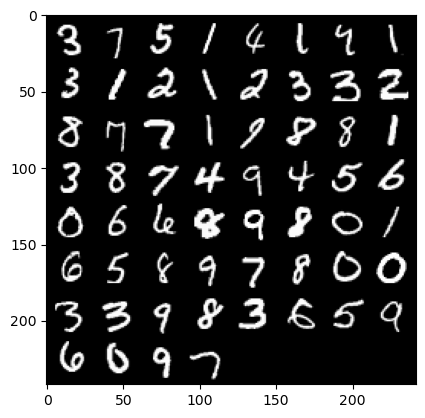

In [8]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
labels

imshow(torchvision.utils.make_grid(images))


# Defining CNN Architecture

In [23]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Building blocks of CNN.

        Parameters: 
            * in_channels: Number of channels in input image.
            * num_classes: Number of classes to predict.
        """
        super(CNN, self).__init__()    # Initialize parent class
        
        # first convolution layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=8,
                               kernel_size=3,
                               padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, 
                               out_channels=16, 
                               kernel_size=3, 
                               padding=1)

        # Fully connected layer
        self.fc1 = nn.Linear(7*7*16, num_classes)

    def forward(self, x):
        """
            * x: Input tensor
        """

        x = F.relu(self.conv1(x))          # Extracting features and applying non-linearity
        x = self.pool(x)                   # Max pooling 
        x = F.relu(self.conv2(x))    
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)      # Flattening
        x = self.fc1(x)                    # Fully connected
        return x

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
model = CNN(in_channels=1, num_classes=10).to(device)

In [26]:
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


# Training the CNN model

In [27]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]


100%|██████████| 1000/1000 [00:15<00:00, 62.59it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:15<00:00, 65.64it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:15<00:00, 66.49it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:16<00:00, 62.20it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:17<00:00, 57.88it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:15<00:00, 66.39it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:15<00:00, 64.59it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:15<00:00, 63.67it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:15<00:00, 62.91it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:15<00:00, 62.84it/s]


# Evaluate the model

In [32]:
from torchmetrics import Accuracy, Precision, Recall

# Define metrics
acc = Accuracy(task="multiclass", num_classes=10)
precision = Precision(task="multiclass", average='macro', num_classes=10)
recall = Recall(task="multiclass", average='macro', num_classes=10)

# Evaluation loop
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)                 # logits
        _, preds = torch.max(outputs, 1)        # predicted class indices

        acc.update(preds, labels)               # update accuracy
        precision.update(preds, labels)         # update precision
        recall.update(preds, labels)            # update recall

# Compute final metrics
test_accuracy = acc.compute()
test_precision = precision.compute()
test_recall = recall.compute()

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")


Test accuracy: 0.9851
Test precision: 0.9850
Test recall: 0.9850
